# Chapter 13: Nonlinear Classification Models

In [1]:
from rpy2 import robjects
from rpy2.robjects.packages import importr, data
import os, warnings
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.rcParams['axes.grid'] = True
plt.gray()

%matplotlib inline
pd.set_option('mode.chained_assignment',None)
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

<Figure size 640x480 with 0 Axes>

In [2]:
base = importr('base')
set_seed = robjects.r("set.seed")
APM = importr('AppliedPredictiveModeling')

## 0. Read Data

In [3]:
# year 2008 has 2075 records, pre 2008 has 6633 records
# Training : pre2008 data + 1557 records in year 2008
# Testing: 518 records in year 2008
training = pd.read_csv('./grantdata_training.csv')
testing = pd.read_csv('./grantdata_testing.csv')
year2008Data = pd.read_csv('./grantdata_year2008Data.csv')

# Full set and Reduced set of features
fullSet = pd.read_csv("./fullset.csv")['colName'].to_list()
reducedSet = pd.read_csv("./reducedset.csv")['colName'].to_list()

print(f"Full set has {len(fullSet)} features, and reduced set has {len(reducedSet)} features.") #1069,  255 changed Day to yDay
print(training.info())
print(testing.info())
print(year2008Data.info())

Full set has 1069 features, and reduced set has 255 features.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Columns: 1894 entries, numCI to Class
dtypes: float64(1890), int64(3), object(1)
memory usage: 118.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Columns: 1894 entries, numCI to Class
dtypes: float64(1890), int64(3), object(1)
memory usage: 7.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Columns: 1894 entries, numCI to Class
dtypes: float64(1890), int64(3), object(1)
memory usage: 30.0+ MB
None


In [4]:
trainData = training[~training.index.isin(year2008Data.index)]
validData = training[training.index.isin(year2008Data.index)]
fillNAcols = ['CI.PhD','DR.PhD','ECI.PhD','HV.PhD','PS.PhD','SR.PhD','EA.PhD','SCI.PhD','UNK.PhD']
trainData[fillNAcols] = trainData[fillNAcols].fillna(0)
validData[fillNAcols] = validData[fillNAcols].fillna(0)

trainData['yDay2'] = trainData['yDay']**2
validData['yDay2'] = validData['yDay']**2

In [5]:
trainX0 = trainData.drop(columns = ['Class'])
trainy0 = trainData['Class'].apply(lambda x : 1 if x =='successful' else 0)
validX0 = validData.drop(columns = ['Class'])
validy0 = validData['Class'].apply(lambda x : 1 if x =='successful' else 0)

In [6]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, get_scorer_names
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning, module = 'sklearn')

sc = StandardScaler()
normalizer = Normalizer()

In [7]:
cv = ShuffleSplit(n_splits = 4, test_size = 0.25, random_state=3)

def modelPerf(model, X, y):
    nl = '\n'
    y_true = y
    y_pred = model.predict(X)
    print(f"Terms: 1 for positive case, and 0 for negative case. \
    {nl}  P - the number of real positive cases in the data \
    {nl}  TP - a test result that correctly indicates the presence of a condition \
    {nl}  FP - a test result which wrongly indicates that a condition is present \
    {nl}  N - the number of real negative cases in the data \
    {nl}  TN - a test result that correctly indicates the absence of a condition \
    {nl}  FN - a test result which wrongly indicates that a condition is absent \
    {nl}  Precision, positive predicitive value(PPV) - TP/(TP+FP) \
    {nl}  Reacll, sensitivity, true positive rate(TPR) - TP/P \
    {nl}  Specificity, selectivity, true negative rate(TNR) - TN/N \
    {nl}  Accuracy - (TP+TN)/(P+N)")
    print(f"The confusion matrix \
    {nl}  TN | FP \
    {nl}  FN | TP")
    print(f"Report of {model.__class__.__name__}:")
    print(classification_report(y_true, y_pred, digits = 7))
    
    f = plt.figure(figsize=(10,4))
    ax1 = f.add_subplot(121)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred), display_labels=model.classes_)
    cmdisp.plot(ax = ax1)
    
    y_score = model.predict_proba(X)[:,1]
    roc_area = roc_auc_score(y_true, y_score)
    ax2 = f.add_subplot(122)
    roc_disp = RocCurveDisplay.from_estimator(model, X, y, ax = ax2)
    print(f"The area under the ROC curve is {roc_area}")

## 1. Nonlinear Discriminant Analysis

In [8]:
trainX = trainX0[reducedSet]
validX = validX0[reducedSet]
trainy = trainy0
validy = validy0

In [9]:
trainX_scaled = sc.fit_transform(trainX)
validX_scaled = sc.fit_transform(validX)

In [10]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis(reg_param =0.5)

In [11]:
qda_param = {'reg_param':np.linspace(0,1,52)}
qdaGS = GridSearchCV(qda, qda_param, cv = cv, scoring = 'roc_auc', n_jobs = -1)
qdaGS.fit(trainX_scaled, trainy)
qdaModel = qdaGS.best_estimator_

In [12]:
qdaModel

QuadraticDiscriminantAnalysis(reg_param=1.0)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of QuadraticDiscriminantAnalysis:
              precision    recall  f1-score   support

           0  0.8015152 0.7671114 0.7839360      3448
           1  0.7147425 0.7544057 0.7340387      2667

    accuracy                      0.7615699    

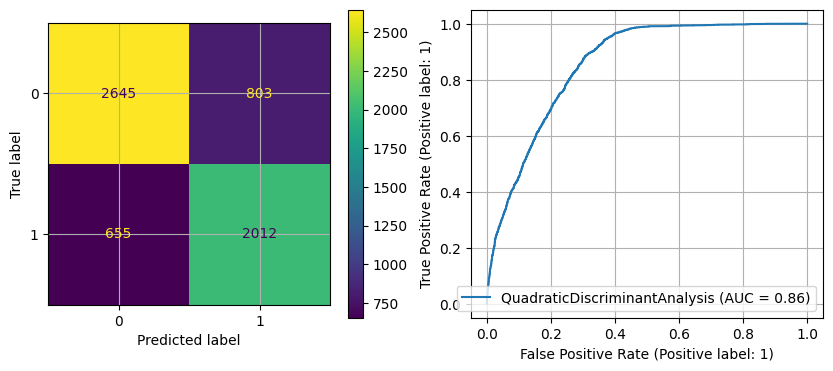

In [13]:
modelPerf(qdaModel,trainX_scaled, trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of QuadraticDiscriminantAnalysis:
              precision    recall  f1-score   support

           0  0.5984321 0.7292994 0.6574163       942
           1  0.7249191 0.5931156 0.6524272      1133

    accuracy                      0.6549398    

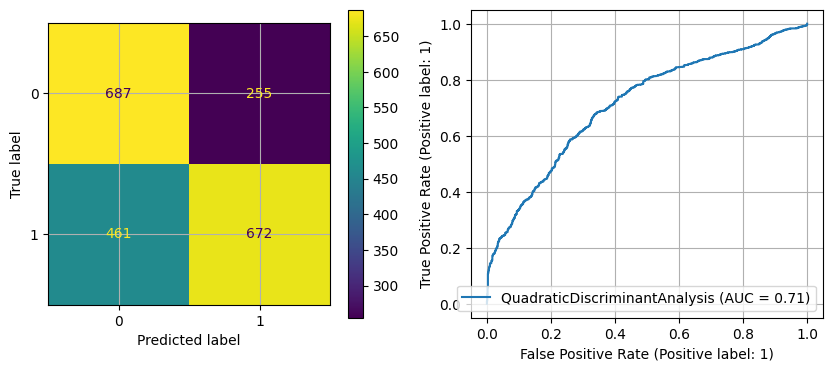

In [14]:
modelPerf(qdaModel,validX_scaled, validy)

## 2. Neural Networks (with 1 hidden layer)

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

### 2.1 Neural Network with 2 predictors

In [11]:
from sklearn.inspection import DecisionBoundaryDisplay

In [235]:
def plot2ClassData(trainX, trainy):
    if type(trainX) != 'pandas.core.frame.DataFrame':
        trainX = pd.DataFrame(trainX)
    if type(trainy) != 'pandas.core.frame.DataFrame':
        trainy = pd.DataFrame(trainy)
        
    colors = ['r', 'b']
    markers = ['o', 's']
    c = ['Class1', 'Class2']
    fig, ax  = plt.subplots()
    for k, m in enumerate(colors):
        i = np.where(trainy.iloc[:,0] == c[k])[0]
        if k == 0:
            ax.scatter(trainX.iloc[i, 0], trainX.iloc[i, 1], 
                        c=m, marker=markers[k], alpha=0.4, s=26, label='Class 1')
        else:
            ax.scatter(trainX.iloc[i, 0], trainX.iloc[i, 1], 
                        c=m, marker=markers[k], alpha=0.4, s=26, label='Class 2')

    ax.set_title('Original Data')
    ax.set_xlabel('Predictor A')
    ax.set_ylabel('Predictor B')
    ax.legend(loc='upper center', ncol=2)
    ax.grid(False)
    return ax

def plotDecisionBoundary(clf, trainX, trainy):
    if type(trainX) != 'pandas.core.frame.DataFrame':
        trainX = pd.DataFrame(trainX)
    if type(trainy) != 'pandas.core.frame.DataFrame':
        trainy = pd.DataFrame(trainy)
        
    colors = ['r', 'b']
    markers = ['o', 's']
    c = ['Class1', 'Class2']
    fig, ax  = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
    clf, trainX, response_method="predict", alpha=0.5,ax =ax, grid_resolution=500)
    for k, m in enumerate(colors):
        i = np.where(trainy.iloc[:,0] == c[k])[0]
        if k == 0:
            ax.scatter(trainX.iloc[i, 0], trainX.iloc[i, 1], 
                        c=m, marker=markers[k], alpha=0.4, s=26, label='Class 1')
        else:
            ax.scatter(trainX.iloc[i, 0], trainX.iloc[i, 1], 
                        c=m, marker=markers[k], alpha=0.4, s=26, label='Class 2')

    ax.set_xlabel('Predictor A')
    ax.set_ylabel('Predictor B')
    ax.legend(loc='upper center', ncol=2)
    ax.grid(False)
    return ax

In [107]:
rdata = pyreadr.read_r("/Users/chenxu/Documents/dataset/AppliedPredictiveModeling/data/twoClassData.RData")

trainX = pd.DataFrame(rdata['predictors'])
trainy = pd.DataFrame(rdata['classes'])
trainX_scaled = pd.DataFrame(sc.fit_transform(trainX))

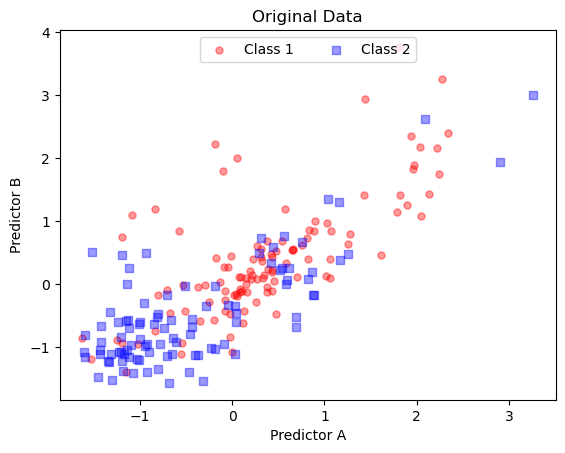

In [239]:
_ = plot2ClassData(trainX_scaled, trainy)

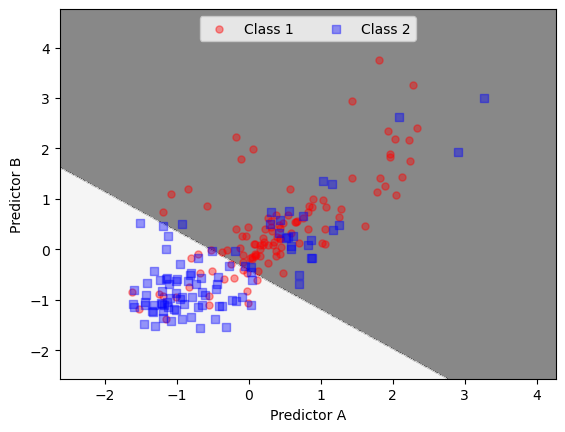

In [267]:
weight_decay = 0.1
clf1 = MLPClassifier(solver ='lbfgs',alpha=weight_decay*208,hidden_layer_sizes=(3,), random_state=20)
clf1.fit(trainX_scaled,trainy)
_ = plotDecisionBoundary(clf1,trainX_scaled, trainy)

In [275]:
n_models = 5
MLPList = []
np.random.seed(seed = 43)
for s in np.random.randint(100,size=n_models):
    MLPList.append(('mlp'+str(len(MLPList)),MLPClassifier(solver ='lbfgs',alpha=weight_decay*208,hidden_layer_sizes=(3,), random_state=s)))

avNN = VotingClassifier(MLPList, voting = 'soft')
avNN.fit(trainX_scaled, trainy)

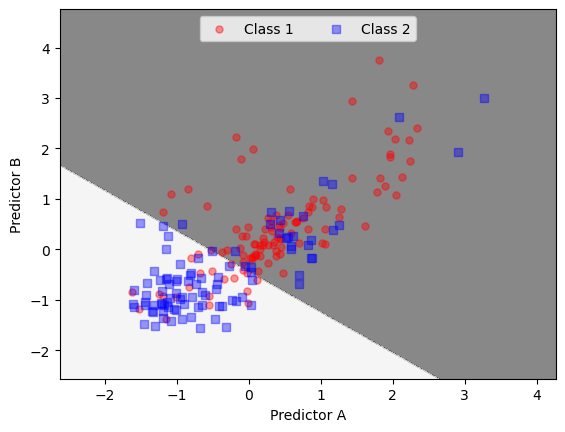

In [276]:
_ = plotDecisionBoundary(avNN,trainX_scaled, trainy)

### 2.2 Grant data with reducedSet

In [17]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [18]:
trainX = trainX0[reducedSet]
trainy = trainy0
validX = validX0[reducedSet]
validy = validy0

trainX_scaled = sc.fit_transform(trainX)
trainX_ss = normalizer.fit_transform(trainX_scaled)

validX_scaled = sc.fit_transform(validX)
validX_ss = normalizer.fit_transform(validX_scaled)

In [19]:
solverList = ['lbfgs','sgd','adam']
hiddenlayerList = [tuple(range(x,x+1)) for x in range(1,11)]

def hyperopt_train_test(params):
    mlp = MLPClassifier(**params,random_state = 419, max_iter = 200)
    return cross_val_score(mlp, trainX_scaled, trainy, cv=4, scoring ='roc_auc', n_jobs = -1).mean()

space4mlp = {
    'solver': hp.choice('solver',solverList),
    'hidden_layer_sizes':hp.choice('hidden_layer_sizes',hiddenlayerList),
    'alpha': hp.uniform('alpha',0,1000)
}

def f(params):
    auc = hyperopt_train_test(params)
    return {'loss': -auc, 'status': STATUS_OK}

trials = Trials()

best_param_mlp = fmin(f, space4mlp, algo=tpe.suggest, max_evals=50, trials=trials)
print('best:', best_param_mlp)

100%|████████| 50/50 [00:43<00:00,  1.15trial/s, best loss: -0.8849195388301125]
best: {'alpha': 108.73278599477918, 'hidden_layer_sizes': 8, 'solver': 0}


In [20]:
for x in best_param_mlp:
    if x =='hidden_layer_size':
        best_param_mlp[x] = hiddenlayerList[best_param_mlp[x]]
    if x =='solver':
        best_param_mlp[x] = solverList[best_param_mlp[x]]
best_param_mlp

{'alpha': 108.73278599477918, 'hidden_layer_sizes': 8, 'solver': 'lbfgs'}

In [314]:
mlp = MLPClassifier()
mlpGS = GridSearchCV(mlp, nnet_param, cv = cv, scoring = 'roc_auc', n_jobs = -1)
mlpGS.fit(trainX_scaled, trainy)

/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

GridSearchCV(cv=ShuffleSplit(n_splits=4, random_state=3, test_size=0.25, train_size=None),
             estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 1, 2],
                         'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                (6,), (7,), (8,), (9,), (10,)],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='roc_auc')

In [315]:
mlpGS.cv_results_

{'mean_fit_time': array([1.31213421, 4.83082181, 5.2226482 , 2.02955312, 5.74747717,
        6.07526845, 2.29807746, 5.88324487, 6.22443622, 2.07250339,
        5.53415245, 5.99586582, 2.67474324, 5.87524629, 6.249309  ,
        2.69332904, 5.8015238 , 6.18968004, 2.30156076, 6.19175065,
        6.67484379, 2.05719161, 5.9914245 , 6.53276432, 1.85640156,
        6.38178134, 6.81529629, 1.49809319, 6.50673997, 7.00304657,
        1.33421749, 4.52710772, 4.67505527, 1.96277273, 5.33356923,
        5.73988146, 2.18118674, 5.74757653, 6.1653344 , 2.01477069,
        5.44209236, 5.96801531, 2.41536236, 5.87977976, 6.3146109 ,
        2.43745381, 6.58955669, 7.30295753, 3.00988919, 7.10803354,
        7.21144831, 2.88661218, 6.21236396, 6.68745899, 2.72462159,
        6.5017814 , 6.93232828, 2.90742749, 6.67034179, 7.14845604,
        1.31617397, 4.65779871, 5.39327472, 2.08372676, 6.09173429,
        6.52835947, 2.36419469, 6.60154718, 7.00265223, 2.19426697,
        5.81777591, 6.53265202,

In [40]:
mlpModel = MLPClassifier(**best_param_mlp)
mlpModel.fit(trainX_scaled,trainy)

MLPClassifier(alpha=100.21469231152864, hidden_layer_sizes=9, solver='lbfgs')

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of MLPClassifier:
              precision    recall  f1-score   support

           0  0.9487943 0.9243039 0.9363890      3448
           1  0.9052975 0.9355081 0.9201549      2667

    accuracy                      0.9291905      6115
   macro 

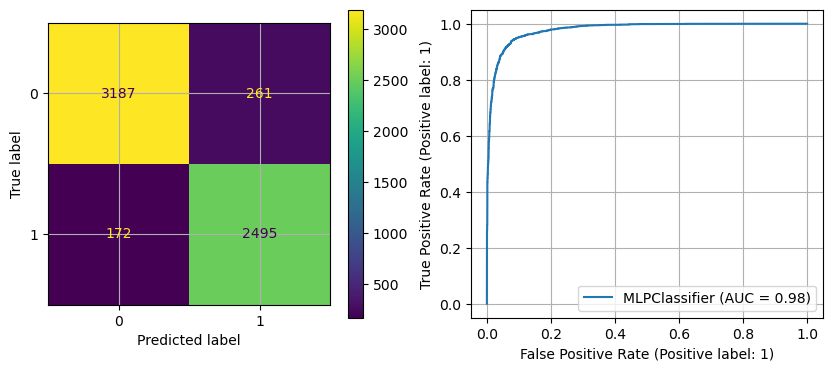

In [41]:
modelPerf(mlpModel,trainX_scaled, trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of MLPClassifier:
              precision    recall  f1-score   support

           0  0.6547515 0.7972399 0.7190043       942
           1  0.7941810 0.6504854 0.7151868      1133

    accuracy                      0.7171084      2075
   macro 

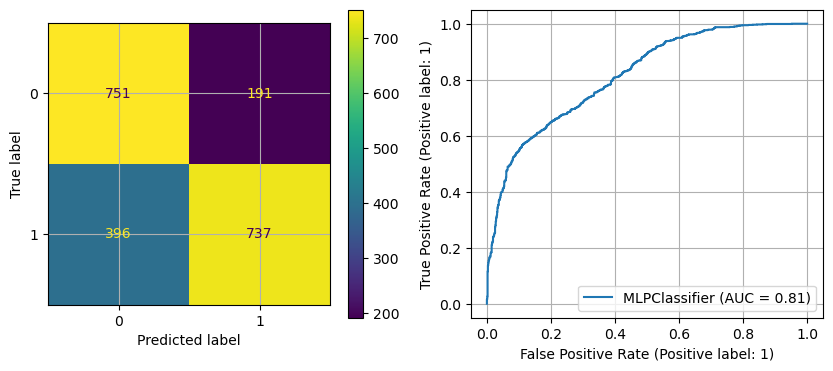

In [42]:
modelPerf(mlpModel,validX_scaled, validy)

In [331]:
mlpGS.fit(trainX_ss, trainy)

/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

GridSearchCV(cv=ShuffleSplit(n_splits=4, random_state=3, test_size=0.25, train_size=None),
             estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 1, 2],
                         'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                (6,), (7,), (8,), (9,), (10,)],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='roc_auc')

In [332]:
mlpModel_ss = mlpGS.best_estimator_

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of MLPClassifier:
              precision    recall  f1-score   support

           0  0.9366529 0.9219838 0.9292605      3448
           1  0.9011393 0.9193851 0.9101707      2667

    accuracy                      0.9208504      6115
   macro 

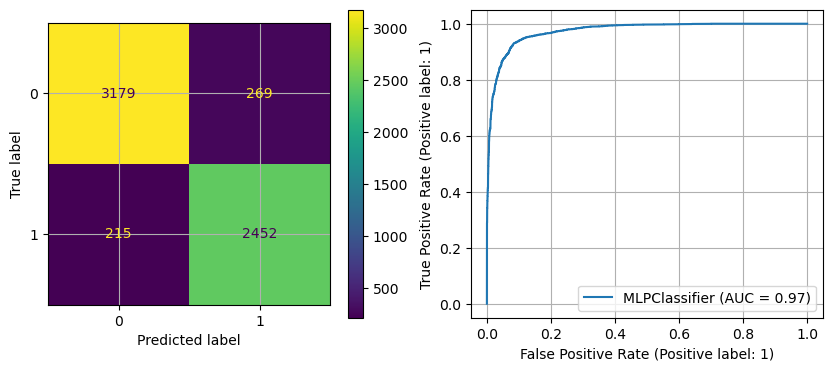

In [333]:
modelPerf(mlpModel_ss, trainX_ss,trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of MLPClassifier:
              precision    recall  f1-score   support

           0  0.6604255 0.8237792 0.7331129       942
           1  0.8155556 0.6478376 0.7220856      1133

    accuracy                      0.7277108      2075
   macro 

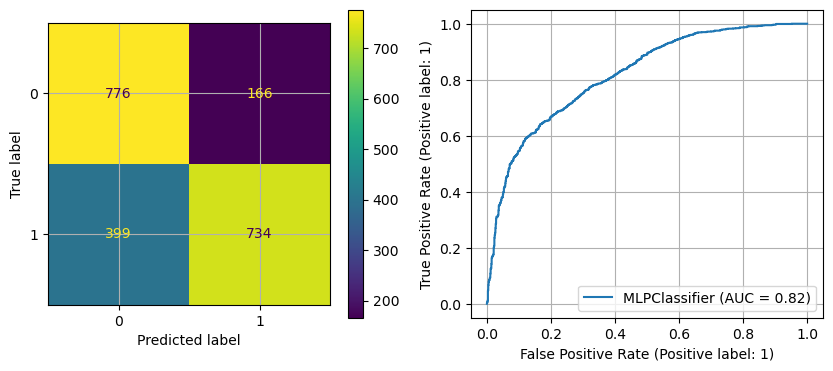

In [334]:
modelPerf(mlpModel_ss, validX_ss,validy)

## 3. Flexible Discriminant Analysis

In [17]:
from pyearth import Earth
from sklearn.linear_model import LogisticRegression

## 4. Support Vector Machine

In [26]:
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [19]:
trainX = trainX0[fullSet]
trainy = trainy0
validX = validX0[fullSet]
validy = validy0

trainX_scaled = sc.fit_transform(trainX)
validX_scaled = sc.fit_transform(validX)

In [35]:
def hyperopt_train_test(params):
    svc = SVC(**params,kernel = 'rbf', random_state = 419, max_iter = 200)
    return cross_val_score(svc, trainX_scaled, trainy, cv=4, scoring ='roc_auc', n_jobs = -1).mean()

space4svc = {
    'C': hp.choice('C',[2]),
    'gamma': hp.loguniform('gamma',-5,0)
}

def f(params):
    auc = hyperopt_train_test(params)
    return {'loss': -auc, 'status': STATUS_OK}

trials = Trials()

best_param_svc = fmin(f, space4svc, algo=tpe.suggest, max_evals=50, trials=trials)
print('best:', best_param_svc)

100%|██████| 50/50 [04:01<00:00,  4.82s/trial, best loss: -0.7598976912146966]
best: {'C': 0, 'gamma': 0.006752751585865851}


In [37]:
for x in best_param_svc:
    if x =='C':
        best_param_svc[x] = [2][best_param_svc[x]]
best_param_svc

{'C': 2, 'gamma': 0.006752751585865851}

In [40]:
svcModel = SVC(kernel = 'rbf', probability = True, random_state = 419, max_iter = 200 ,**best_param_svc)
svcModel.fit(trainX_scaled,trainy)

SVC(C=2, gamma=0.006752751585865851, max_iter=200, probability=True,
    random_state=419)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of SVC:
              precision    recall  f1-score   support

           0  0.9531145 0.4127030 0.5759968      3448
           1  0.5618780 0.9737533 0.7125806      2667

    accuracy                      0.6573998      6115
   macro avg  0.757

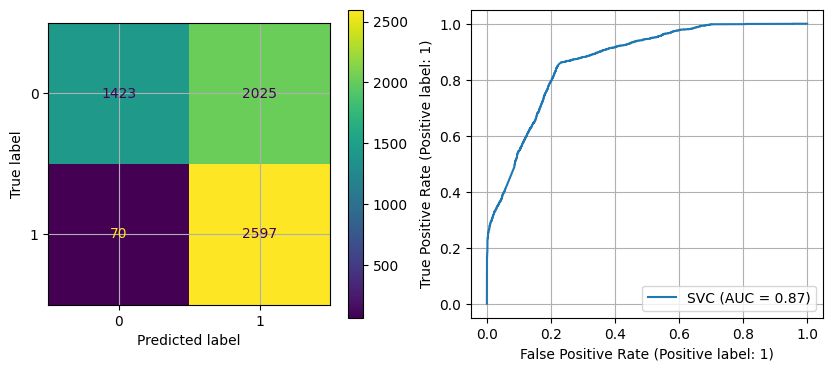

In [41]:
modelPerf(svcModel,trainX_scaled, trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of SVC:
              precision    recall  f1-score   support

           0  0.6853933 0.3885350 0.4959350       942
           1  0.6262167 0.8517211 0.7217651      1133

    accuracy                      0.6414458      2075
   macro avg  0.655

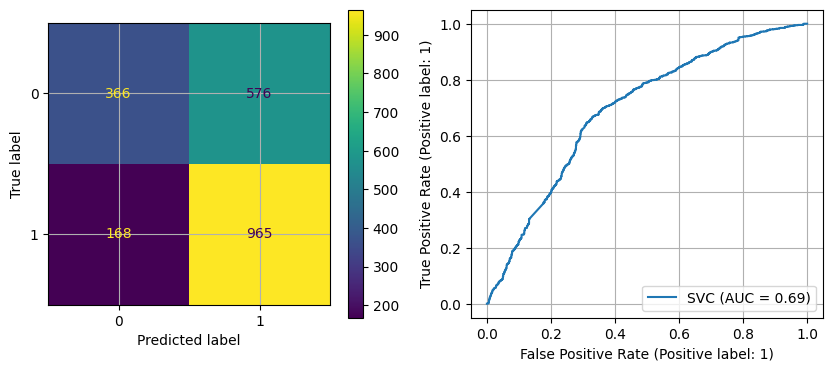

In [42]:
modelPerf(svcModel,validX_scaled, validy)

In [43]:
trainX = trainX0[reducedSet]
trainy = trainy0
validX = validX0[reducedSet]
validy = validy0

trainX_scaled = sc.fit_transform(trainX)
validX_scaled = sc.fit_transform(validX)

In [44]:
def hyperopt_train_test(params):
    svc = SVC(**params,kernel = 'rbf', random_state = 419, max_iter = 200)
    return cross_val_score(svc, trainX_scaled, trainy, cv=4, scoring ='roc_auc', n_jobs = -1).mean()

space4svc = {
    'C': hp.loguniform('C',-5,2),
    'gamma': hp.loguniform('gamma',-5,2)
}

def f(params):
    auc = hyperopt_train_test(params)
    return {'loss': -auc, 'status': STATUS_OK}

trials = Trials()

best_param_svc = fmin(f, space4svc, algo=tpe.suggest, max_evals=50, trials=trials)
print('best:', best_param_svc)

100%|██████| 50/50 [00:46<00:00,  1.07trial/s, best loss: -0.7990109048128473]
best: {'C': 0.5867248702490199, 'gamma': 0.014933828642850552}


In [45]:
svcModel_reduced = SVC(kernel = 'rbf', probability = True, random_state = 419, max_iter = 200 ,**best_param_svc)
svcModel_reduced.fit(trainX_scaled,trainy)

SVC(C=0.5867248702490199, gamma=0.014933828642850552, max_iter=200,
    probability=True, random_state=419)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of SVC:
              precision    recall  f1-score   support

           0  0.6763052 0.9767981 0.7992406      3448
           1  0.9295154 0.3955756 0.5549711      2667

    accuracy                      0.7233034      6115
   macro avg  0.802

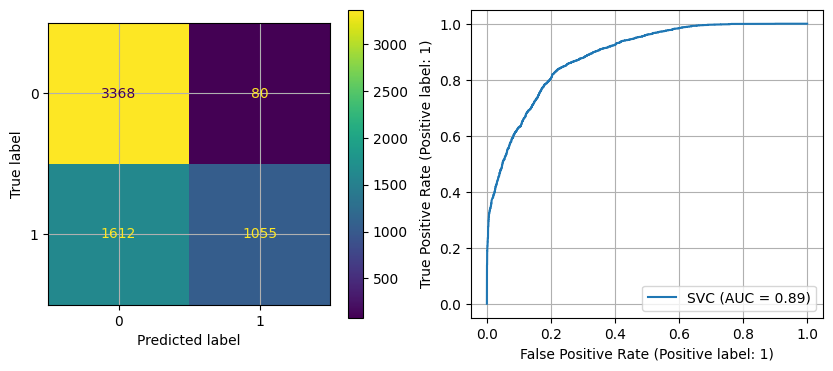

In [46]:
modelPerf(svcModel_reduced, trainX_scaled, trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of SVC:
              precision    recall  f1-score   support

           0  0.5008923 0.8938429 0.6420130       942
           1  0.7461929 0.2594881 0.3850688      1133

    accuracy                      0.5474699      2075
   macro avg  0.623

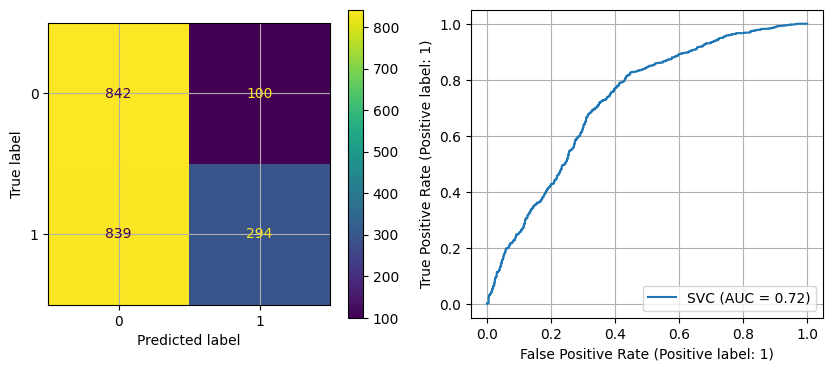

In [47]:
modelPerf(svcModel_reduced, validX_scaled, validy)

## 5. K-Nearest Neighbors

In [61]:
trainX = trainX0[reducedSet]
trainy = trainy0
validX = validX0[reducedSet]
validy = validy0

trainX_scaled = sc.fit_transform(trainX)
validX_scaled = sc.fit_transform(validX)

In [94]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [95]:
nhbrList = [1+4*x for x in range(0,5)]+[1+20*x for x in range(1,5)]+[1+50*x for x in range(2,10)]

knn_param = {'n_neighbors':nhbrList}
knnGS = GridSearchCV(knn, knn_param, cv = cv, scoring = 'roc_auc', n_jobs = -1)
knnGS.fit(trainX_scaled, trainy)
knnModel = knnGS.best_estimator_

In [96]:
knnModel

KNeighborsClassifier(n_neighbors=451)

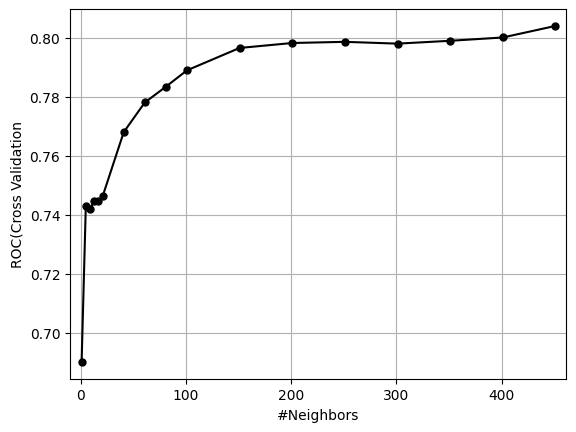

In [98]:
fig, ax  = plt.subplots()
plt.plot(nhbrList, knnGS.cv_results_['mean_test_score'],'-o', c = 'black',markersize= 5)
_=plt.xlim(-10,451+10)
_=plt.xlabel('#Neighbors')
_=plt.ylabel('ROC(Cross Validation')

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of KNeighborsClassifier:
              precision    recall  f1-score   support

           0  0.6508386 0.9341647 0.7671788      3448
           1  0.8053173 0.3520810 0.4899556      2667

    accuracy                      0.6802944      6115
  

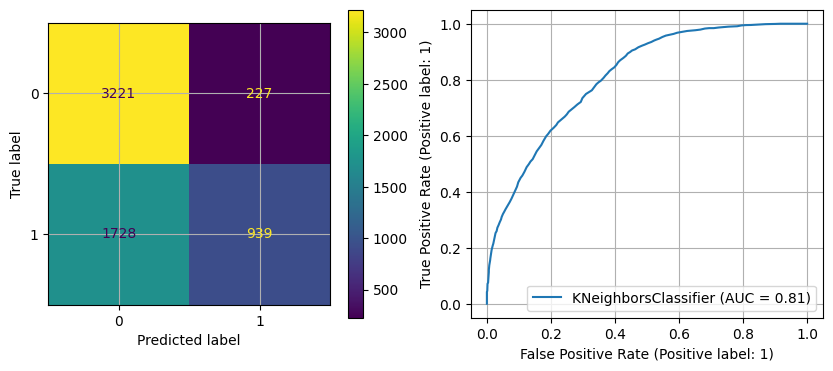

In [99]:
modelPerf(knnModel, trainX_scaled, trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of KNeighborsClassifier:
              precision    recall  f1-score   support

           0  0.4912380 0.9225053 0.6410918       942
           1  0.7614379 0.2056487 0.3238360      1133

    accuracy                      0.5310843      2075
  

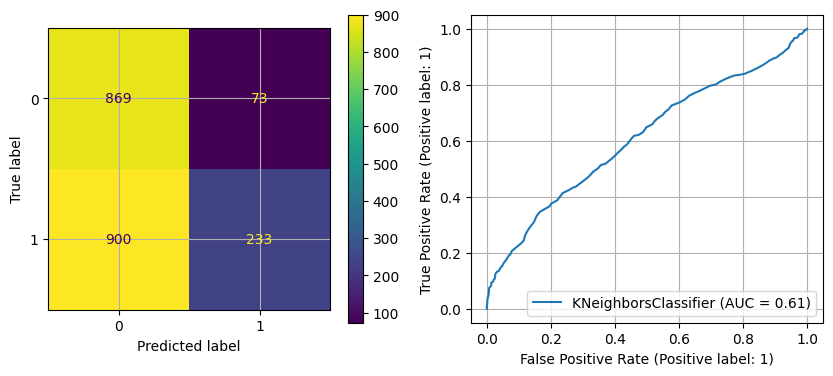

In [100]:
modelPerf(knnModel, validX_scaled, validy)

## 6. Naive Bayes